[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Optimization Results:
---------------------
Optimized Parameters: [0.]

Evaluation Criteria:
-------------------
Cumulative Returns: 3.576265497506406
Maximum Drawdown: 0.0
Sharpe Ratio: 2.3283367493448646


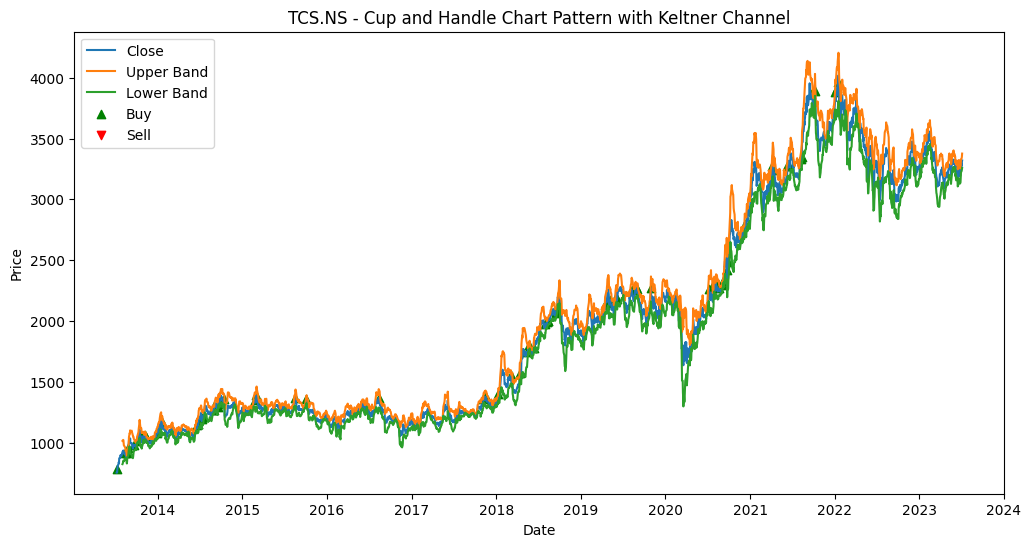

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define a function to check if the given data matches the Cup and Handle pattern
def is_cup_and_handle(data):
    # Calculate the moving average of the highs and lows
    highs_ma = data['High'].rolling(window=20, min_periods=1).mean()
    lows_ma = data['Low'].rolling(window=20, min_periods=1).mean()

    # Calculate the handle support and resistance levels
    handle_support = lows_ma.min()
    handle_resistance = highs_ma.max()

    # Check if the pattern matches the Cup and Handle criteria
    if (
        data['High'][-1] > handle_resistance and
        data['Low'][-1] > handle_support and
        data['Low'][-1] < handle_resistance and
        data['Close'][-1] > data['Close'][-2] and
        data['Close'][-1] > data['Open'][-1]
    ):
        return True

    return False

# Define a function to generate buy/sell signals based on the Cup and Handle pattern and Keltner Channel
def generate_signals(data):
    # Calculate the Keltner Channel
    data['Typical'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['ATR'] = data['Typical'].rolling(window=20).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
    data['UpperBand'] = data['Typical'] + 2 * data['ATR']
    data['LowerBand'] = data['Typical'] - 2 * data['ATR']

    # Generate buy/sell signals based on the Cup and Handle pattern and Keltner Channel
    signals = []
    for i in range(len(data)):
        if is_cup_and_handle(data[:i+1]):
            if data['Close'][i] > data['UpperBand'][i]:
                signals.append(-1)  # Sell signal
            else:
                signals.append(1)  # Buy signal
        else:
            signals.append(0)  # Hold signal

    # Add the signals to the data DataFrame
    data['Signal'] = signals

    return data

# Define a function to calculate the evaluation criteria
def evaluate_strategy(params, data):
    # Generate buy/sell signals using the given parameters
    signals = generate_signals(data)

    # Calculate the daily returns based on the signals
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['StrategyReturns'] = data['Returns'] * signals['Signal']

    # Calculate the cumulative returns
    cumulative_returns = (1 + data['StrategyReturns']).cumprod()

    # Calculate the maximum drawdown
    cumulative_roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / cumulative_roll_max - 1
    max_drawdown = drawdown.min()

    # Calculate the annualized Sharpe ratio
    sharpe_ratio = np.sqrt(252) * data['StrategyReturns'].mean() / data['StrategyReturns'].std()

    # Calculate the objective function value (negative Sharpe ratio)
    objective = -sharpe_ratio

    return objective

# Define the optimization function
def optimize_strategy(symbol):
    # Download historical data from Yahoo Finance
    data = yf.download(symbol, start='2013-07-07', end='2023-07-06')

    # Download historical data from Yahoo Finance
    data = yf.download(symbol, start='2013-07-07', end='2023-07-06')

    # Define the optimization function
    def optimize(params):
        return evaluate_strategy(params, data)

    # Define the initial guess for the optimization parameters
    initial_params = [0]

    # Perform the optimization
    result = minimize(optimize, initial_params, method='SLSQP', bounds=[(-1, 1)])

    # Get the optimized parameters
    optimized_params = result.x

    # Generate buy/sell signals using the optimized parameters
    signals = generate_signals(data)

    # Calculate the daily returns based on the signals
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['StrategyReturns'] = data['Returns'] * signals['Signal']

    # Calculate the cumulative returns
    cumulative_returns = (1 + data['StrategyReturns']).cumprod()

    # Calculate the maximum drawdown
    cumulative_roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / cumulative_roll_max - 1
    max_drawdown = drawdown.min()

    # Calculate the annualized Sharpe ratio
    sharpe_ratio = np.sqrt(252) * data['StrategyReturns'].mean() / data['StrategyReturns'].std()

    # Print the optimization results and evaluation criteria
    print('Optimization Results:')
    print('---------------------')
    print('Optimized Parameters:', optimized_params)
    print()
    print('Evaluation Criteria:')
    print('-------------------')
    print('Cumulative Returns:', cumulative_returns[-1])
    print('Maximum Drawdown:', max_drawdown)
    print('Sharpe Ratio:', sharpe_ratio)

    # Plot the data with buy/sell signals
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close')
    plt.plot(data['UpperBand'], label='Upper Band')
    plt.plot(data['LowerBand'], label='Lower Band')
    plt.scatter(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['Close'], marker='^', color='g', label='Buy')
    plt.scatter(data[data['Signal'] == -1].index, data[data['Signal'] == -1]['Close'], marker='v', color='r', label='Sell')
    plt.title(f'{symbol} - Cup and Handle Chart Pattern with Keltner Channel')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Run the optimization for a specific stock symbol (e.g., Tata Consultancy Services)
symbol = 'TCS.NS'
optimize_strategy(symbol)
